## Introduction

### Recently I started with NLP and after going through several articles and algorithms I thought to implement it. So in this kernel I am try to implement them. Data is of Stack OverFlow and I'll try to understand what the key words are in the coupus. 

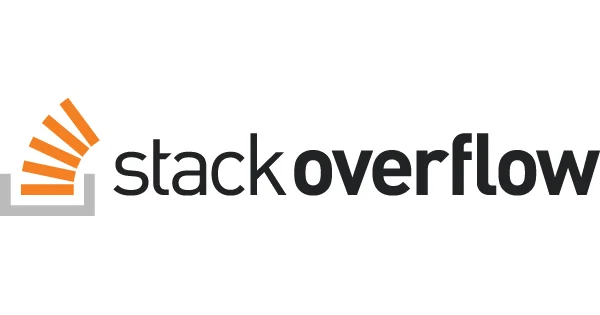

## Table -- 
1. [ Getting Started](#The_Data) 
    * [Import Liberay](#Lib)
    * [Explore Data](#Display)
2. [Pre-Processing](#Pre-Processing) 
    * [Cleaning Text](#Cleaning)
    * [Bigrams](#Bigrams)
    * [Most Frequent Words](#Frequent)
3. [Training the model](#Model)
    * [The parameters](#parms)
    * [Building the Vocabulary Table](#Vocab)
    * [Training of the model](#Training)
4. [Exploring the model](#Exploring)
    * [Most similar to](#similar)
    * [t-SNE visualizations](#t-SNE)
5. [PLOTS](#PLOTS)
6. [Conclusion](#Conclusion)

## <a id="The_Data">The Data : </a>

Its a collection of 60,000 Stack Overflow questions from 2016-2020 and classified them into three categories:

HQ: High-quality posts with 30+ score and without a single edit.
LQ_EDIT: Low-quality posts with a negative score and with multiple community edits. However, they still remain open after the edits.
LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.


## <a id="Lib">Import Liberay </a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as tf
import seaborn as sns
import re
import random
import warnings

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

warnings.simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data = pd.read_csv("/kaggle/input/60k-stack-overflow-questions-with-quality-rate/data.csv")

## <a id="Display"> Let's look at the Data</a>

In [ ]:
display(data.info(),data.head())

## <a id='Pre-Processing'>Pre-Processing</a> 

Note:- We are currently going to use only two columns but we are still going to keep 2 more columns just for later use
<ul>
  <li>1. <code> Id , CreationDate </code> were not usefull at the current point. </li>
  <li>2. And let's transform the <code> 'Y' </code> column into " 0,1,2 " </li>
</ul>

In [ ]:
dummy_data = data[['Title','Body','Tags','Y']]
dummy_data['Y'] = dummy_data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
dummy_data.head()

### Again let's combine <code> 'Text' = Title and Body </code> 

In [ ]:
dummy_data['text'] = dummy_data['Title'] + ' ' + dummy_data['Body']
dummy_data = dummy_data.drop(['Title', 'Body'], axis=1)
dummy_data.head()

## <a id='Cleaning'>Cleaning Text</a> 

### We are lemmatizing and removing the stopwords and non-alphabetic characters for each line . 
### For this purpose we are using SpaCy and its build-in pipeline for this purpose.

In [ ]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    #remove stopwords + Lemmitze them 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # word2vec uses context words to learn the vector representation of a terget word 
    # if sentence is only one or two worlds long,
    # the benifit for training them is small thus we may drop them 
    if len(txt)>2:
        return ' '.join(txt)

### Removing characters other than alpha numeric characters 

In [ ]:
init_cleaning = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in dummy_data['text'])

### Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [ ]:
t = time()

#batch size used if a document is having words more than 5000 treat it as a seperate doc
txt = [cleaning(doc) for doc in nlp.pipe(init_cleaning,batch_size=5000,n_threads=-1)]

print('Time too clean up everything: {} mins'.format(round((time() - t)/60,2)))

## Cleaned Data: 
Now that we have cleaned data lets store it in a new dataframe and drop any null/ missing values or duplicates 

In [ ]:
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

In [ ]:
df_clean

In [ ]:
df_clean['Y'] = dummy_data['Y']
df_clean

In [ ]:
del dummy_data
del nlp
del init_cleaning

In [ ]:
a = df_clean.iloc[0:40000]
X_train = a['clean']
y_train = a['Y']

b = df_clean.iloc[40000:60000]
X_test = b['clean']
y_test = b['Y']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train=X_train.toarray()
X_test=X_test.toarray()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
model = Sequential()
model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(x=X_train,y=y_train,epochs=40,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop])